In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
sess = tf.Session()

# RNNのパラメータを設定
num_layers = 3 # RNNの層の数
min_word_freq = 5 # 出現頻度がこの値以下の単語を除外
rnn_size = 128 # RNNモデルのサイズ（埋め込みサイズに等しい）
epochs = 10 # データを処理する回数
batch_size = 100 # 一度にトレーニングするサンプルの数
learning_rate = 0.001 # 学習率（収束パラメータ）
training_seq_len = 50 # 前後（左右）の単語の数（左右に25単語ずつ）
embedding_size = rnn_size # 埋め込みサイズ（rnn_sizeに等しい）
save_every = 500 # モデルを保存する頻度（500回おき）
eval_every = 50 # テスト文を評価する頻度
# テストのリスト
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

In [3]:
# シェイクスピアのテキストデータをダウンロードして格納
data_dir = 'temp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)

# ハイフンとアポストロフィ以外の句読点を削除
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

In [4]:
# モデルフォルダを作成
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)

# データフォルダを作成
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
print('Loading Shakespeare Data')
# ファイルがダウンロードされているかどうかを確認
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Not found, downloading Shakespeare texts from www.gutenberg.org')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    # シェイクスピアのテキストデータを取得
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    # バイナリデータを文字列にデコード
    s_text = shakespeare_file.decode('utf-8')
    # 最初の部分に含まれている説明用の段落を削除
    s_text = s_text[7675:]
    # 改行を削除
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    
    # ファイルに保存
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    # ファイルがすでに保存されている場合は、そのファイルからデータを読み込む
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')

Loading Shakespeare Data
Not found, downloading Shakespeare texts from www.gutenberg.org


In [5]:
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text ).strip().lower()

# 文字ごとに分割
char_list = list(s_text)

In [6]:
def build_vocab(characters):
    character_counts = collections.Counter(characters)
    # 文字からインデックスへのマッピングを作成
    chars = character_counts.keys()
    vocab_to_ix_dict = {key:(ix+1) for ix, key in enumerate(chars)}
    # 不明なキーのインデックスとして0を追加
    vocab_to_ix_dict['unknown']=0
    # インデックスから語彙へのマッピングを作成
    ix_to_vocab_dict = {val:key for key,val in vocab_to_ix_dict.items()}
    
    return(ix_to_vocab_dict, vocab_to_ix_dict)

# シェイクスピアの語彙を作成
ix2vocab, vocab2ix = build_vocab(char_list)
vocab_size = len(ix2vocab)

In [7]:
# テキストを単語ベクトルに変換
s_text_ix = []
for x in char_list:
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

In [8]:
# LSTM RNN モデルを作成
class LSTM_Model():
    # モデルのすべての変数と演算を定義
    def __init__(self, embedding_size, rnn_size, num_layers, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size)
        self.lstm_cell = tf.contrib.rnn.MultiRNNCell([self.lstm_cell for _ in range(self.num_layers)])
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        
        with tf.variable_scope('lstm_vars'):
            # ソフトマックスの出力の重み
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
        
            # 埋め込みを定義
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
                                            
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
                
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell)
        # 推測されていない出力
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        # ロジットと出力
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)
        
        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocab_size)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
        
    # サンプル（単語）をループ処理してテキストを生成
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=20, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        char_list = list(prime_text)
        for char in char_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        char = char_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            char = words[sample]
            out_sentence = out_sentence + char
        return(out_sentence)

In [9]:
# LSTM モデルを定義
lstm_model = LSTM_Model(embedding_size, rnn_size, num_layers, batch_size, learning_rate,
                        training_seq_len, vocab_size)

# テストモデル定義。このスコープをテストに再利用する
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, num_layers, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

In [10]:
# モデルの保存関数を定義
saver = tf.train.Saver(tf.global_variables())

# エポックごとにバッチを作成
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
# テキストインデックスを同じサイズの部分配列に分割
batches = np.array_split(s_text_ix, num_batches)
# それらの部分配列の形状を [batch_size, training_seq_len] に変更
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

# すべての変数を初期化
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    # 単語インデックスをシャッフル
    random.shuffle(batches)
    # シャッフルしたバッチから目的値を作成
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # エポックの実行を開始
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    # LSTMの初期状態をエポックごとにリセット
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        # 各RNNセルの初期状態を更新する
        for i, (c, h) in enumerate(lstm_model.initial_state):
                    training_dict[c] = state[i].c
                    training_dict[h] = state[i].h
        
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        
        # 10回おきにステータスを出力
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        
        # モデルと語彙を保存
        if iteration_count % save_every == 0:
            # モデルを保存
            model_file_name = os.path.join(full_model_dir, 'model')
            saver.save(sess, model_file_name, global_step = iteration_count)
            print('Model Saved To: {}'.format(model_file_name))
            # 語彙を保存
            dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            with open(dictionary_file, 'wb') as dict_file_conn:
                pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        
        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))
                
        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 950, Loss: 2.99
Iteration: 20, Epoch: 1, Batch: 20 out of 950, Loss: 2.89
Iteration: 30, Epoch: 1, Batch: 30 out of 950, Loss: 2.91
Iteration: 40, Epoch: 1, Batch: 40 out of 950, Loss: 2.86
Iteration: 50, Epoch: 1, Batch: 50 out of 950, Loss: 2.87
thou art more  atte e a
to be or not to e atte  a
wherefore art thou  ete te a
Iteration: 60, Epoch: 1, Batch: 60 out of 950, Loss: 2.81
Iteration: 70, Epoch: 1, Batch: 70 out of 950, Loss: 2.76
Iteration: 80, Epoch: 1, Batch: 80 out of 950, Loss: 2.75
Iteration: 90, Epoch: 1, Batch: 90 out of 950, Loss: 2.71
Iteration: 100, Epoch: 1, Batch: 100 out of 950, Loss: 2.67
thou art more an an an 
to be or not to he an an 
wherefore art thou he an an 
Iteration: 110, Epoch: 1, Batch: 110 out of 950, Loss: 2.62
Iteration: 120, Epoch: 1, Batch: 120 out of 950, Loss: 2.55
Iteration: 130, Epoch: 1, Batch: 130 out of 950, Loss: 2.49
Iteration: 140, Epoch: 1, Batch: 140 out of 950, Loss: 

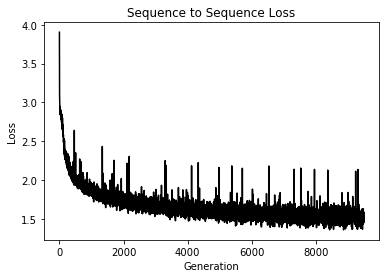

In [12]:
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()